In [1]:
import json
import gensim
import nltk
import string
import scipy
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt
#from tqdm import tqdm

C:\Users\yizho\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Load alumni data and discipline data from json file

In [2]:
data = json.load(open('data.json'))
discipline = json.load(open('disciplines.json'))

In [3]:
def tokenization(text):
    """
    This function takes a a string of text. Then tokenize it.
    
    Args:
        text: a text string
    Returns:
        a list of tokens(words)
    """
    stpwords = stopwords.words('english')
    text = text.lower()
    proc = ''
    i = 0
    while i < len(text):
        c = text[i]
        #remove punctuation
        if c not in string.punctuation:
            proc+=c
        elif c == "'":
            if i == (len(text)-1):
                break
            if text[i+1] == 's' and (i+2) == len(text):
                break
            if text[i+1] == 's' and text[i+2] == ' ':
                i+=1
        else:
            proc+=' '
        i+=1  
    #tokenization by nltk
    tokens = nltk.word_tokenize(proc)
    #remove stop words in tokens
    result = []
    for word in tokens:
        if word not in stpwords:
            result.append(word)
    return result

# Tokenize all alumni data

In [4]:
tokenized_data = {}
for school in data.keys():
    tokenized_data[school] = {}
    for person in data[school].keys():
        tokenized_data[school][person] = tokenization(data[school][person])

In [5]:
with open('tokenized_data.json', 'w') as fp:
    json.dump(tokenized_data, fp)

# Embedding all alumni data

In [6]:
#load google word2vec model
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [8]:
def embedding(tokens, model):
    """
    This function takes a list of tokens(words), and a pretrained word2vec model in gensim.
        Then transform the tokens into a single vector.
    Args: 
        tokens: a list of string representing the tokens
        model: a pretrained word2vec gensim model
    returns:
        vec: a np array representing the tokens.
    """
    vec = None
    for word in tokens:
        #if the model does not contain the word. just skip it
        if word not in model.vocab:
            continue
        if type(vec) != type(None):
            vec = vec + model[word]
        else:
            vec = model[word]
    return vec

In [9]:
processed_data = {}
for school in tokenized_data.keys():
    processed_data[school] = {}
    for person in data[school].keys():
        processed_data[school][person] = embedding(tokenized_data[school][person],model)

In [10]:
np.savez('vec_data.npz', **processed_data)

In [31]:
data_vec = np.load('vec_data.npz')


In [11]:
data_vec = processed_data

# Handle Discipline


In [13]:

del(discipline['Space sciences'])

KeyError: 'Space sciences'

In [14]:
tokenized_discipline = {}
discipline_vec = {}
for academic in discipline.keys():
    #tokenize 
    tokenized_discipline[academic] = []
    for text in discipline[academic]:
      tokenized_discipline[academic].extend(tokenization(text))
    #doc2vec
    discipline_vec[academic] = embedding(tokenized_discipline[academic],model)
    

In [15]:
np.savez('vec_discipline.npz', **discipline_vec)
with open('tokenized_discipline.json', 'w') as fp:
    json.dump(tokenized_discipline, fp)

In [50]:
#for academic in discipline_vec.keys():
    #print(academic, discipline_vec[academic])
    
print(discipline['Space sciences'])
print(tokenized_discipline['Space sciences'])

KeyError: 'Space sciences'

# Cosine Similarity

## Scores: py dict

```
{ <school name1>: {
            <academic>: [[score1, score2, score3, ....],
                     [(name1,score1), (name2,score2), ...]]
              ...
            }
   ...
 }
```

In [19]:
scores = {}
for school in data_vec.keys():
    scores[school] = {}
    for academic in discipline_vec.keys():
        scores[school][academic] = [[],[]]
        displi = discipline_vec[academic]
        for name in data_vec[school].keys():
            alumni = data_vec[school][name]
            scores[school][academic][0].append(1- scipy.spatial.distance.cosine(alumni,displi))
            scores[school][academic][1].append((1- scipy.spatial.distance.cosine(alumni,displi),name))


In [53]:
with open('similarity_score.json', 'w') as fp:
    json.dump(scores, fp)

In [22]:
final_scores = {}
for school in scores.keys():
    final_scores[school] = {}
    for academic in scores[school].keys():
        final_scores[school][academic] = np.mean(scores[school][academic][0])
     

In [23]:
plot_dict = {}
for school in final_scores.keys():
    for academic in final_scores[school].keys():
        if academic not in plot_dict.keys():
            plot_dict[academic] = [[],[]]
        plot_dict[academic][0].append(school)
        plot_dict[academic][1].append(final_scores[school][academic])

In [24]:
print(plot_dict.keys())

dict_keys(['Arts', 'History', 'Languages and literature', 'Philosophy', 'Theology', 'Anthropology', 'Economics', 'Human geography', 'Law', 'Political science', 'Psychology', 'Sociology', 'Biology', 'Chemistry', 'Earth sciences', 'Physics', 'Computer Science', 'Mathematics', 'Statistics', 'Engineering and technology', 'Medicine and health'])


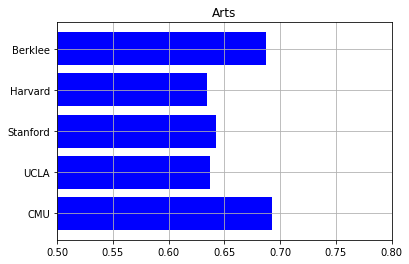

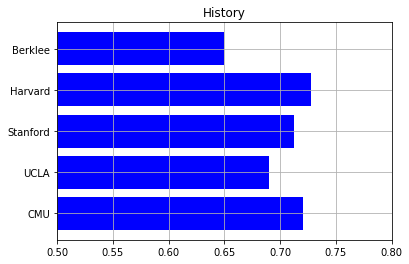

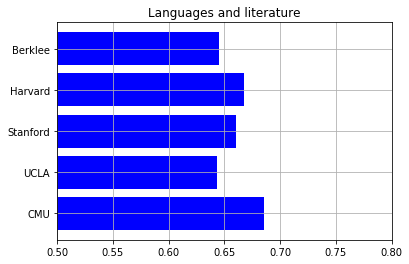

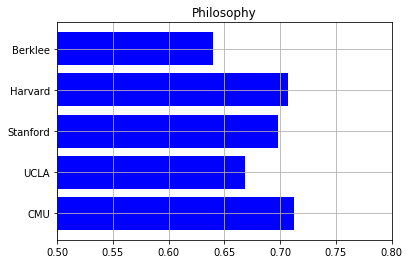

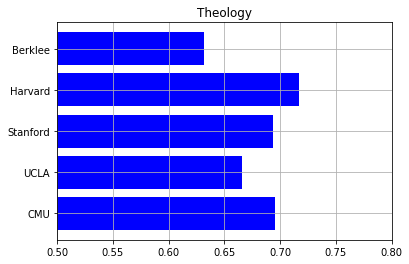

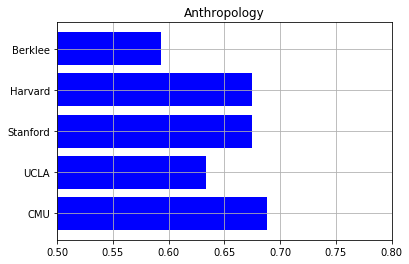

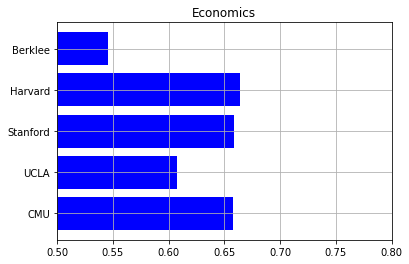

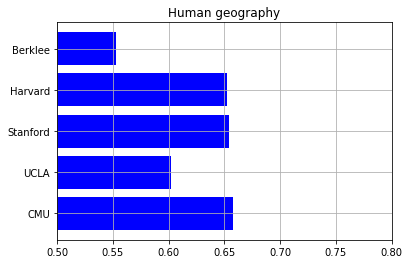

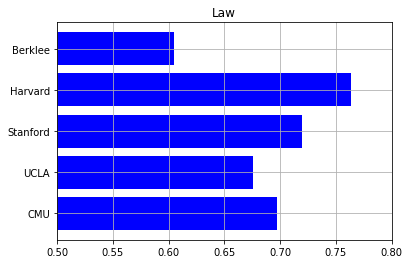

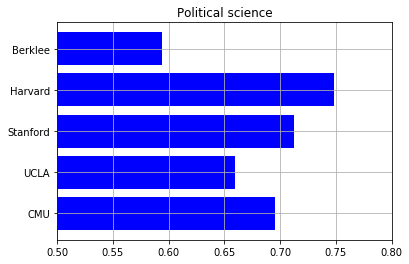

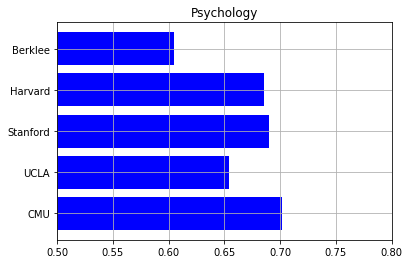

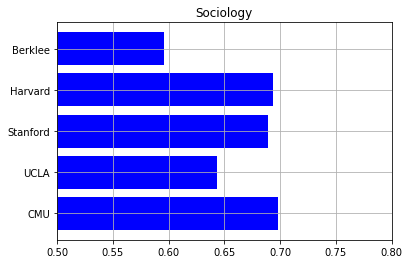

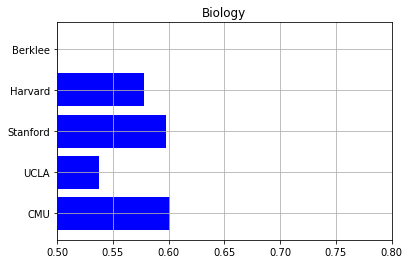

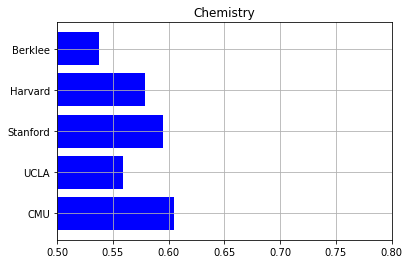

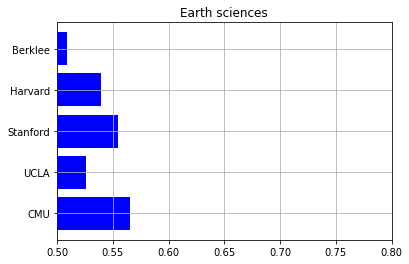

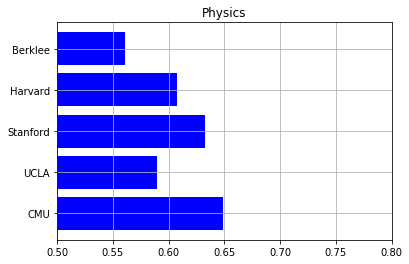

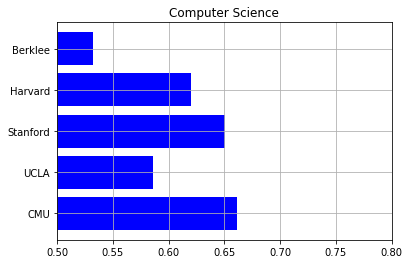

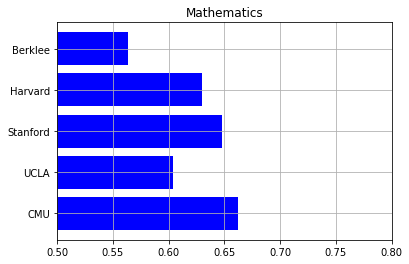

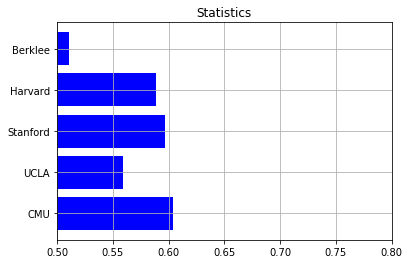

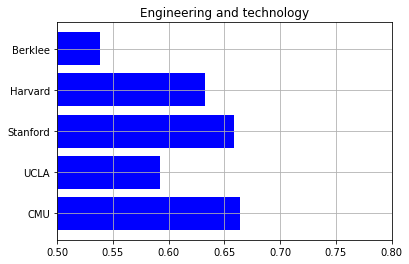

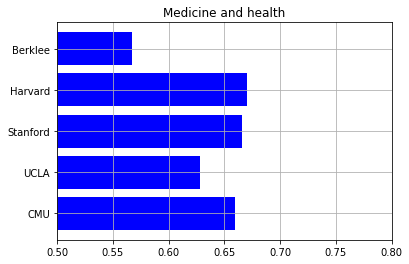

In [25]:
for key in plot_dict.keys(): 
    x = plot_dict[key][0]
    y = plot_dict[key][1]
    plt.barh(range(len(x)), y, color = 'b')
    plt.yticks(range(len(x)),x)
    plt.title(key)
    plt.xlim(0.5, 0.8)
    plt.grid()
    plt.show()

In [29]:

for academic in scores['CMU'].keys():
    print(academic)
    scores['CMU'][academic][1].sort(reverse=True)
   
    for i in range(5):
        print(scores['CMU'][academic][1][i])

Arts
(0.8978172540664673, 'Golan_Levin')
(0.8845943212509155, 'Joyce_Kozloff')
(0.8836503624916077, 'Richard_Rappaport')
(0.8698902726173401, 'Philip_Pearlstein')
(0.8555537462234497, 'Mel_Bochner')
History
(0.8993697762489319, 'Harrison_White')
(0.8885684609413147, 'Herbert_A._Simon')
(0.8780751824378967, 'Jeffrey_Pfeffer')
(0.870668351650238, 'Brian_MacWhinney')
(0.8635125756263733, 'Walter_Dill_Scott')
Languages and literature
(0.9012560844421387, 'Brian_MacWhinney')
(0.8689244985580444, 'Herbert_A._Simon')
(0.8423580527305603, 'Harrison_White')
(0.8409110307693481, 'Walter_Dill_Scott')
(0.8381473422050476, 'George_Loewenstein')
Philosophy
(0.9062706828117371, 'Herbert_A._Simon')
(0.8966803550720215, 'Harrison_White')
(0.8813345432281494, 'Dana_Scott')
(0.8813345432281494, 'Dana_S._Scott')
(0.877239465713501, 'George_Loewenstein')
Theology
(0.8613532185554504, 'Harrison_White')
(0.8521102070808411, 'Herbert_A._Simon')
(0.8411178588867188, 'John_Forbes_Nash')
(0.8402970433235168, 'Je